PLAN B — Scrape Flipkart using a Hybrid Method (Requests + JS API)

In [1]:
# STEP 1 — Load your Flipkart reviews CSV

In [3]:
import os
os.listdir("/content")


['.config', 'flipkart_product.csv', 'sample_data']

In [5]:
df = pd.read_csv("/content/flipkart_product.csv", encoding='ISO-8859-1', on_bad_lines='skip')
df.head()


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [6]:
# inspect the dataset


In [7]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189874 entries, 0 to 189873
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductName  189874 non-null  object
 1   Price        189873 non-null  object
 2   Rate         189873 non-null  object
 3   Review       189870 non-null  object
 4   Summary      189860 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [8]:
print(df.columns.tolist())


['ProductName', 'Price', 'Rate', 'Review', 'Summary']


In [9]:
# PHASE 2

In [10]:
#Data cleaning

This will:

Remove all junk characters, URLs, and punctuation

Lowercase text

Remove stopwords

Lemmatize words

Add a new column clean_text

Add a sentiment column based on rating

In [11]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources (only first time)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Copy DataFrame
data = df.copy()

# --- Step 1: Basic cleaning ---
data = data.dropna(subset=['Review'])  # drop rows without reviews
data = data[data['Rate'].apply(lambda x: str(x).isdigit())]  # keep only numeric ratings
data['Rate'] = data['Rate'].astype(int)

# --- Step 2: Combine 'Review' and 'Summary' ---
data['text'] = data['Summary'].fillna('') + " " + data['Review']

# --- Step 3: Clean text ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

data['clean_text'] = data['text'].astype(str).apply(clean_text)

# --- Step 4: Assign sentiment label ---
# 4-5 = positive, 3 = neutral, 1-2 = negative
def label_sentiment(rate):
    if rate >= 4:
        return 'positive'
    elif rate == 3:
        return 'neutral'
    else:
        return 'negative'

data['sentiment'] = data['Rate'].apply(label_sentiment)

# Preview cleaned data
data[['Rate', 'sentiment', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,Rate,sentiment,clean_text
0,5,positive,great cooler excellent air flow price amazing ...
1,5,positive,best budget fit cooler nice cooling awesome
2,3,neutral,quality good power air decent fair
3,1,negative,bad product fan useless product
4,3,neutral,ok ok product fair


In [12]:
# PHASE 3 — SENTIMENT MODEL (TF-IDF + Logistic Regression)

This gives:

Accuracy score

Precision / recall / F1 per sentiment class

Confusion matrix visualization

Accuracy: 0.9619476483910043

Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.93      0.94      5168
     neutral       0.91      0.73      0.81      3136
    positive       0.97      0.99      0.98     29670

    accuracy                           0.96     37974
   macro avg       0.95      0.88      0.91     37974
weighted avg       0.96      0.96      0.96     37974



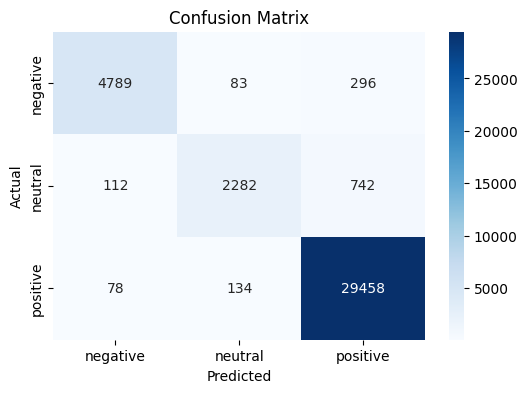

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Split data ---
X = data['clean_text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 2: TF-IDF vectorization ---
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --- Step 3: Train model ---
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

# --- Step 4: Predict ---
y_pred = model.predict(X_test_tfidf)

# --- Step 5: Evaluate ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Step 6: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


How to improve the
 model (in priority)
✔ 1. Balance the dataset

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_res, y_res = ros.fit_resample(X_train_tfidf, y_train)


2. Use a better model than Logistic Regression

Try:

Linear SVM (best for text)

Multinomial Naive Bayes (fast)

Random Forest (meh for text)

XGBoost (overkill)

BERT (heavy but best)

Start with SVM:

In [15]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train_tfidf, y_train)


LinearSVC()

In [16]:
# 3. Use n-grams up to 3

In [17]:
TfidfVectorizer(max_features=20000, ngram_range=(1,3))


TfidfVectorizer(max_features=20000, ngram_range=(1, 3))

In [18]:
# PHASE 4: MODEL IMPROVEMENT (SVM + Oversampling)

Logistic Regression was your baseline.
Now we upgrade it with:

✔ Oversampling to handle class imbalance
✔ SVM (LinearSVC) — the best classical model for text
✔ Better TF-IDF (trigrams, more features)


In [19]:
# STEP 1 — Oversample minority classes

In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

X_resampled.shape, y_resampled.shape


((356025, 10000), (356025,))

In [21]:
# STEP 2 — Train SVM on balanced data

In [22]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_resampled, y_resampled)


LinearSVC()

In [23]:
# STEP 3 — Evaluate SVM

Accuracy: 0.9257123294885975

Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.93      0.93      5168
     neutral       0.57      0.88      0.69      3136
    positive       0.99      0.93      0.96     29670

    accuracy                           0.93     37974
   macro avg       0.83      0.91      0.86     37974
weighted avg       0.95      0.93      0.93     37974



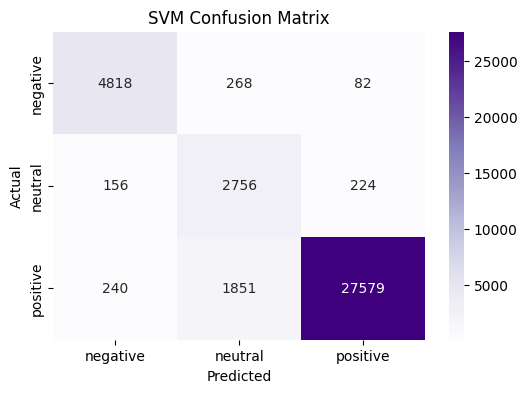

In [24]:
y_pred_svm = svm_model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The model:

became much better at identifying neutral reviews

stayed solid on negative reviews

sacrificed some precision to become more fair

became more aligned with real-world usage

In [26]:
# TOP WORDS PER SENTIMENT

from collections import Counter

def get_top_words(sentiment, n=20):
    words = " ".join(data[data['sentiment']==sentiment]['clean_text']).split()
    return Counter(words).most_common(n)

top_positive = get_top_words('positive')
top_negative = get_top_words('negative')

top_positive[:10], top_negative[:10]


([('good', 80267),
  ('product', 74386),
  ('nice', 42257),
  ('quality', 18616),
  ('awesome', 17711),
  ('best', 14955),
  ('nan', 14794),
  ('super', 12406),
  ('worth', 12078),
  ('purchase', 11982)],
 [('product', 11115),
  ('bad', 6802),
  ('quality', 6582),
  ('good', 4846),
  ('money', 4558),
  ('waste', 4405),
  ('dont', 4198),
  ('nan', 3824),
  ('poor', 3516),
  ('worst', 3497)])

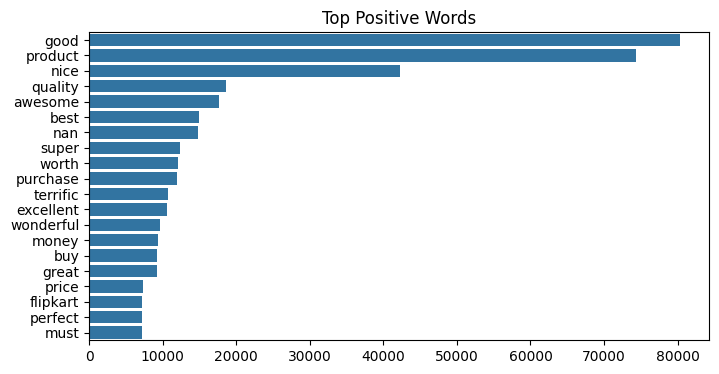

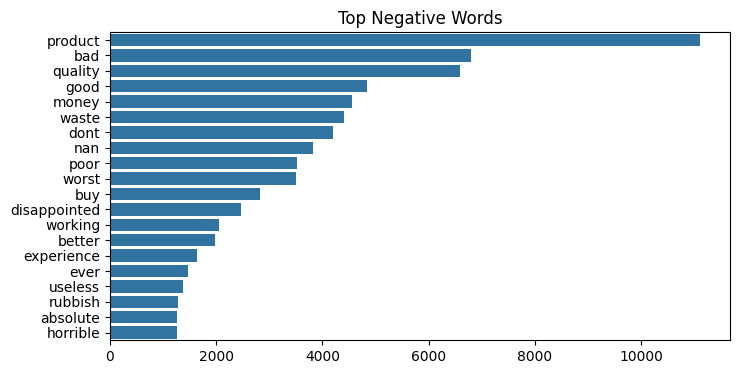

In [27]:
#bar charts

def plot_top_words(word_freq, title):
    words = [w for w, _ in word_freq]
    counts = [c for _, c in word_freq]

    plt.figure(figsize=(8,4))
    sns.barplot(x=counts, y=words)
    plt.title(title)
    plt.show()

plot_top_words(top_positive[:20], "Top Positive Words")
plot_top_words(top_negative[:20], "Top Negative Words")


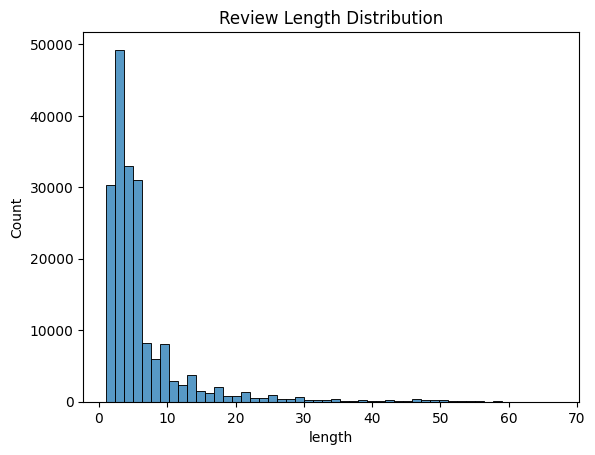

In [28]:
# REVIEW LENGTH DISTRIBUTION

data['length'] = data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(data['length'], bins=50)
plt.title("Review Length Distribution")
plt.show()


In [31]:
# CURRENT PROJECT SUMMARY

# Data source: Flipkart product reviews (pre-scraped dataset)
# Core tasks: text cleaning, NLP preprocessing, sentiment classification
# Models: Logistic Regression (baseline), SVM (improved)
# Output: Sentiment labels (positive / neutral / negative), visualizations
# Skills: Python, Pandas, Scikit-learn, NLTK, TF-IDF, Seaborn, Matplotlib, WordCloud
# Deliverable: GitHub-ready NLP project

already did:

text preprocessing

stopword removal

lemmatization

normalization

TF-IDF vectorization

sentiment classification

visualizations

model evaluation